In [1]:
import os

import numpy as np

import torch
from fno.utils import get_num_params, get_seed
from fno.pipeline import *
from fno.datasets import *
from fno.losses import *
from fno.sfno import SFNO
from fno.visualizations import plot_contour_trajectory
from torch.utils.data import DataLoader

get_seed(1127825)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
TRAIN_PATH = TEST_PATH = os.path.join(
    DATA_PATH, "McWilliams2d_64x64_N1152_Re1000_T100.pt"
)

Ntrain = 1024
Ntest = 64

batch_size = 4

epochs = 15
learning_rate = 1e-2

n = 64
T = 10
fs = "vorticity"

modes = 32
modes_t = 5
width = 10
beta = -1e-2


model_name = f"sfno_Re1000_N{Ntrain}_ep{epochs}_m{modes}_w{width}.pt"

path_model = os.path.join(MODEL_PATH, model_name)
print(TRAIN_PATH)
print(model_name)


/home/scao/Documents/torch-cfd/data/McWilliams2d_64x64_N1152_Re1000_T100.pt
sfno_Re1000_N1024_ep15_m32_w10.pt


In [3]:
train_dataset = SpatioTemporalDataset(
    data_path=TRAIN_PATH,
    n_samples=Ntrain,
    steps=T,
    out_steps=T,
)
test_dataset = SpatioTemporalDataset(
    data_path=TEST_PATH, n_samples=Ntest, steps=T, out_steps=T, train=False
)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width, beta=beta).to(device)

print(get_num_params(model))

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    div_factor=1e3,
    final_div_factor=1e4,
    steps_per_epoch=len(train_loader),
    epochs=epochs,
)

l2diff = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)


16469791


In [13]:
for ep in range(epochs):
    model.train()
    train_l2 = 0

    with tqdm(total=len(train_loader)) as pbar:
        for i, data in enumerate(train_loader):
            l2 = train_batch_ns(
                model,
                l2diff,
                data,
                optimizer,
                device,
            )
            train_l2 += l2.item()
            is_epoch_scheduler = any(
                s in str(scheduler.__class__) for s in EPOCH_SCHEDULERS
            )
            if not is_epoch_scheduler:
                scheduler.step()

            if i % 4 == 0:
                pbar.set_description(f"train rel L2: {l2.item():.4e}")
                pbar.update(4)

    test_l2_min = 1e4
    test_l2 = eval_epoch_ns(
        model,
        l2diff,
        test_loader,
        device,
    )

    if test_l2 < test_l2_min:
        torch.save(model.state_dict(), path_model)
        test_l2_min = test_l2

    print(
        f"\nEpoch {ep+1} | ",
        f"Train L2: {train_l2/len(train_loader):.5e} |",
        f"Test  L2: {test_l2:.5e}\n",
    )


  0%|          | 0/256 [00:00<?, ?it/s]

train rel L2: 2.5415e-01: 100%|██████████| 256/256 [00:07<00:00, 32.93it/s]



Epoch 1 |  Train L2: 2.94550e-01 | Test  L2: 2.48261e-01



train rel L2: 2.0928e-01: 100%|██████████| 256/256 [00:07<00:00, 36.53it/s]



Epoch 2 |  Train L2: 2.28612e-01 | Test  L2: 2.04835e-01



train rel L2: 1.5019e-01: 100%|██████████| 256/256 [00:06<00:00, 36.98it/s]



Epoch 3 |  Train L2: 1.71589e-01 | Test  L2: 1.42282e-01



train rel L2: 1.2508e-01: 100%|██████████| 256/256 [00:06<00:00, 36.99it/s]



Epoch 4 |  Train L2: 1.31235e-01 | Test  L2: 1.23328e-01



train rel L2: 1.0274e-01: 100%|██████████| 256/256 [00:07<00:00, 35.10it/s]



Epoch 5 |  Train L2: 1.12786e-01 | Test  L2: 1.18151e-01



train rel L2: 9.3574e-02: 100%|██████████| 256/256 [00:06<00:00, 36.87it/s]



Epoch 6 |  Train L2: 1.01444e-01 | Test  L2: 9.33668e-02



train rel L2: 8.3628e-02: 100%|██████████| 256/256 [00:06<00:00, 37.25it/s]



Epoch 7 |  Train L2: 9.28242e-02 | Test  L2: 8.72365e-02



train rel L2: 9.0726e-02: 100%|██████████| 256/256 [00:06<00:00, 36.93it/s]



Epoch 8 |  Train L2: 8.64262e-02 | Test  L2: 8.41527e-02



train rel L2: 7.4125e-02: 100%|██████████| 256/256 [00:06<00:00, 38.63it/s]



Epoch 9 |  Train L2: 8.04084e-02 | Test  L2: 7.85832e-02



train rel L2: 7.8043e-02: 100%|██████████| 256/256 [00:06<00:00, 36.85it/s]



Epoch 10 |  Train L2: 7.50227e-02 | Test  L2: 7.30931e-02



train rel L2: 6.5504e-02: 100%|██████████| 256/256 [00:07<00:00, 36.41it/s]



Epoch 11 |  Train L2: 7.03902e-02 | Test  L2: 6.92643e-02



train rel L2: 6.4749e-02: 100%|██████████| 256/256 [00:06<00:00, 36.76it/s]



Epoch 12 |  Train L2: 6.71201e-02 | Test  L2: 6.54357e-02



train rel L2: 6.5272e-02: 100%|██████████| 256/256 [00:07<00:00, 36.15it/s]



Epoch 13 |  Train L2: 6.46277e-02 | Test  L2: 6.37715e-02



train rel L2: 5.7286e-02: 100%|██████████| 256/256 [00:07<00:00, 35.41it/s]



Epoch 14 |  Train L2: 6.26866e-02 | Test  L2: 6.30527e-02



train rel L2: 6.2292e-02: 100%|██████████| 256/256 [00:07<00:00, 35.93it/s]



Epoch 15 |  Train L2: 6.22802e-02 | Test  L2: 6.27012e-02



In [14]:
torch.cuda.empty_cache()
model = SFNO(modes, modes, modes_t, width).to(device)
model.load_state_dict(torch.load(path_model))
preds = []
gt_solns = []
test_l2_all = []
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
loss_func = SobolevLoss(n_grid=n, norm_order=0, time_average=True, relative=True)

with torch.no_grad():
    model.eval()
    for i, (x, y) in enumerate(test_loader):
        x, y = x[fs].to(device), y[fs].to(device)
        out = model(x)

        preds.append(out)
        gt_solns.append(y)

        test_l2 = loss_func(out, y).item()
        test_l2_all.append(test_l2)

preds = torch.cat(preds, dim=0)
gt_solns = torch.cat(gt_solns, dim=0)
print(f"Test relative L2: {np.mean(test_l2_all):.5e} +/- {np.std(test_l2_all):.5e}")


Test relative L2: 6.25601e-02 +/- 8.51579e-03


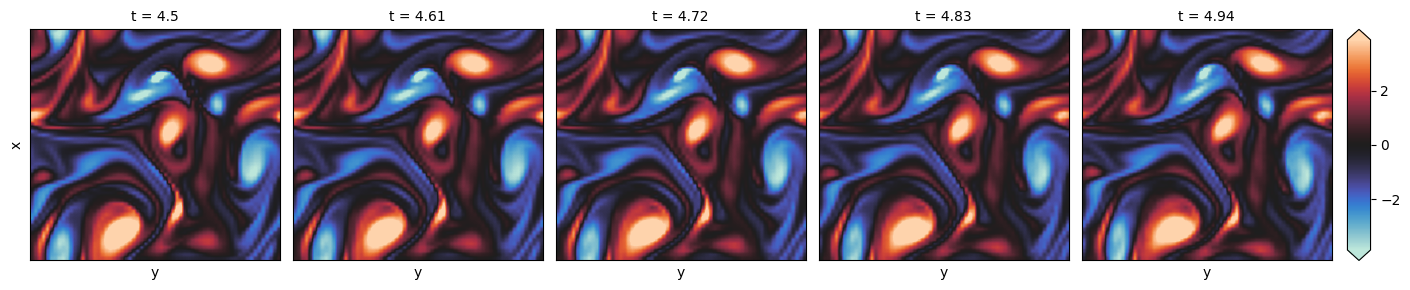

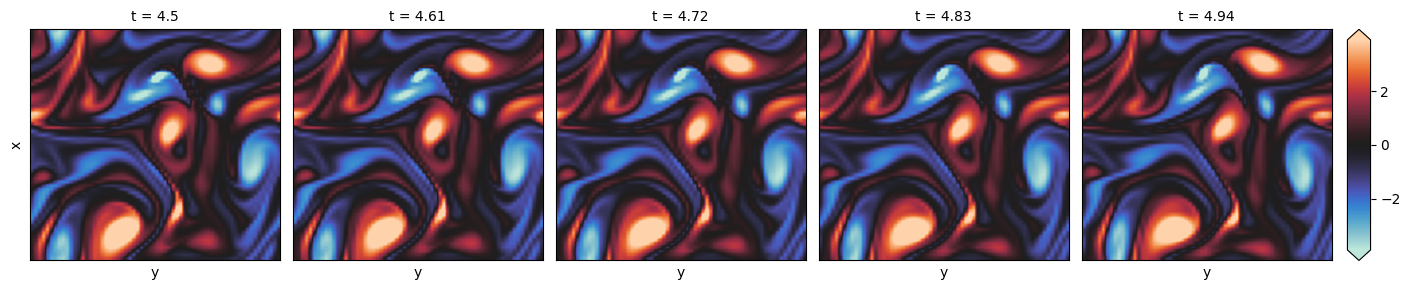

In [16]:
idx = np.random.randint(0, Ntest)
plot_contour_trajectory(preds[idx], num_snapshots=5, T_start=4.5, dt=5.5 / 100)
plot_contour_trajectory(gt_solns[idx], num_snapshots=5, T_start=4.5, dt=5.5 / 100)
